## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
import torchsummary


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here

            nn.Linear(input_shape, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
       BatchNorm1d-3                  [-1, 256]             512
              ReLU-4                  [-1, 256]               0
           Dropout-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 302,218
Trainable params:

Your experiments come here:

In [9]:
import torch.optim as optim

lr = 5e-4

model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

num_epochs = 30

def train_fasion(model, train_loader, opt, loss_func, num_epochs=10):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            
            
            out = model(data)
            loss = loss_func(out, target)
            
           
            opt.zero_grad()
            loss.backward()
            opt.step()

            epoch_train_loss += loss.item()

            _, predicted = torch.max(out.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

        train_loss.append(epoch_train_loss / len(train_loader))
        train_acc.append(correct_train / total_train)


        model.eval()
        epoch_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for data, target in test_loader:
                data = data.to(device)
                target = target.to(device)
                out = model(data)
                loss = loss_func(out, target) 
                epoch_test_loss += loss.item()
                _, predicted = torch.max(out.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        test_loss.append(epoch_test_loss / len(test_loader))
        test_acc.append(correct_test / total_test)

        print('Epoch: {} \tTrain Loss: {:.6f} \tTrain Acc: {:.3f} \tTest Loss: {:.6f} \tTest Accuracy: {:.3f}'.format(
            epoch, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))

    return train_loss, train_acc, test_loss, test_acc, model


# Your experiments, training and validation loops here

train_loss_1, train_acc_1, test_loss_1, test_acc_1, model_1 = train_fasion(model, train_loader, opt, loss_func, num_epochs=num_epochs)

Epoch: 0 	Train Loss: 0.572785 	Train Acc: 0.814 	Test Loss: 0.425999 	Test Accuracy: 0.842
Epoch: 1 	Train Loss: 0.389661 	Train Acc: 0.860 	Test Loss: 0.365589 	Test Accuracy: 0.865
Epoch: 2 	Train Loss: 0.352152 	Train Acc: 0.872 	Test Loss: 0.362823 	Test Accuracy: 0.866
Epoch: 3 	Train Loss: 0.328636 	Train Acc: 0.878 	Test Loss: 0.335899 	Test Accuracy: 0.875
Epoch: 4 	Train Loss: 0.308694 	Train Acc: 0.887 	Test Loss: 0.323834 	Test Accuracy: 0.878
Epoch: 5 	Train Loss: 0.295637 	Train Acc: 0.892 	Test Loss: 0.315568 	Test Accuracy: 0.880
Epoch: 6 	Train Loss: 0.286918 	Train Acc: 0.893 	Test Loss: 0.326452 	Test Accuracy: 0.879
Epoch: 7 	Train Loss: 0.271946 	Train Acc: 0.899 	Test Loss: 0.311379 	Test Accuracy: 0.885
Epoch: 8 	Train Loss: 0.264021 	Train Acc: 0.902 	Test Loss: 0.316418 	Test Accuracy: 0.882
Epoch: 9 	Train Loss: 0.257511 	Train Acc: 0.904 	Test Loss: 0.302229 	Test Accuracy: 0.886
Epoch: 10 	Train Loss: 0.248818 	Train Acc: 0.907 	Test Loss: 0.307653 	Test Acc

In [10]:
def plot_func(train_loss, train_acc, test_loss, test_acc, name=""):
    plt.figure(figsize=(12, 6))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o', label=f'Train Loss for {name}NeuralNetwork')
    # plt.plot(range(1, len(test_losses_relu1) + 1), test_losses_relu1, marker='o', label='Test Loss w/o BatchNorm Adam')
    plt.plot(range(1, len(test_loss) + 1), test_loss, marker='o', label=f'Test Loss for {name}NeuralNetwork')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.grid(True)
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_acc) + 1), train_acc, marker='o', label=f'Train Accuracy for {name}NeuralNetwork')
    # plt.plot(range(1, len(test_accuracies_relu1) + 1), test_accuracies_relu1, marker='o',  label='Test Accuracy w/o BatchNorm Adam')
    plt.plot(range(1, len(test_acc) + 1), test_acc, marker='o', label=f'Test Accuracy for {name}NeuralNetwork')
    plt.axhline(y=0.885, color='r', linestyle='--', label='Target Accuracy (0.885)') # Горизонтальная линия
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.grid(True)
    plt.legend()
    plt.suptitle('Comparison of Loss and Accuracy for Train and Test data')
    plt.tight_layout()

    plt.show()

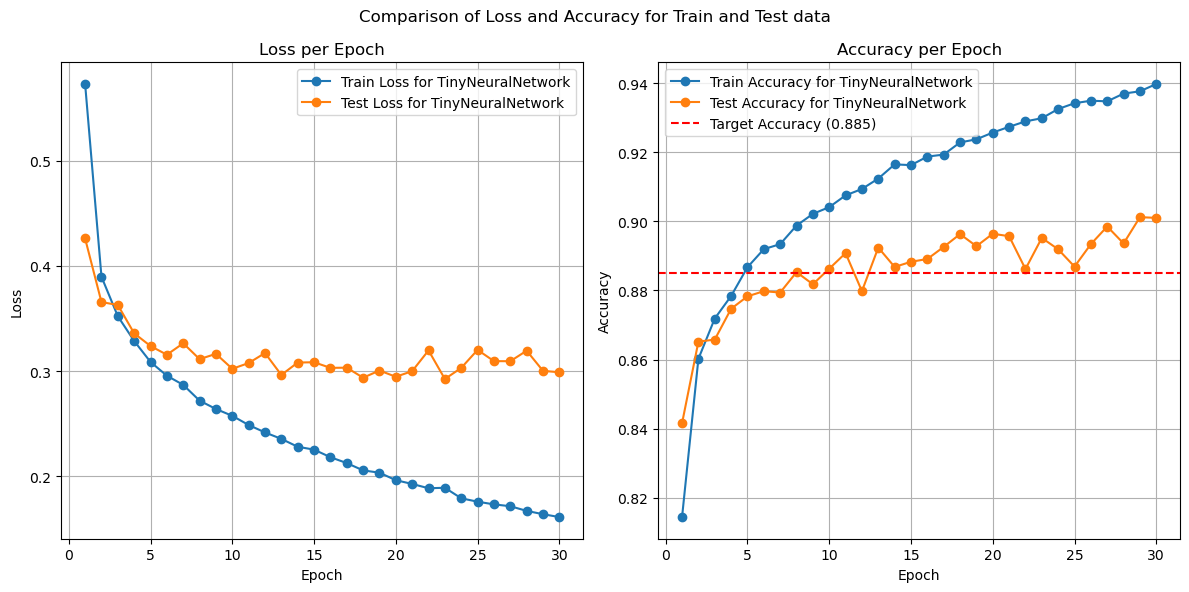

In [11]:
plot_func(train_loss_1, train_acc_1, test_loss_1, test_acc_1, 'Tiny')

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [13]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 4096]      16,781,312
              ReLU-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
              ReLU-7                 [-1, 4096]               0
            Linear-8                 [-1, 4096]      16,781,312
              ReLU-9                 [-1, 4096]               0
           Linear-10                   [-1, 10]          40,970
Total params: 53,600,266
Trainable params: 53,600,266
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 204.47
Est

In [14]:
# Уменьшаем размер обучающего набора данных для того чтобы модель гарантированно переобучилась

small_train_set = torch.utils.data.Subset(fmnist_dataset_train, range(2000))
small_train_loader = torch.utils.data.DataLoader(small_train_set, batch_size=128, shuffle=True, num_workers=2)

In [15]:
model = OverfittingNeuralNetwork().to(device)
# opt = # YOUR CODE HERE
# loss_func = # YOUR CODE HERE


lr = 1e-3
opt = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

num_epochs = 50

train_loss_2, train_acc_2, test_loss_2, test_acc_2, model_2 = train_fasion(model, small_train_loader, opt, loss_func, num_epochs=num_epochs)
# Your experiments, come here

Epoch: 0 	Train Loss: 1.702491 	Train Acc: 0.380 	Test Loss: 1.140071 	Test Accuracy: 0.563
Epoch: 1 	Train Loss: 0.873693 	Train Acc: 0.646 	Test Loss: 0.750442 	Test Accuracy: 0.703
Epoch: 2 	Train Loss: 0.635357 	Train Acc: 0.752 	Test Loss: 0.657811 	Test Accuracy: 0.753
Epoch: 3 	Train Loss: 0.562383 	Train Acc: 0.780 	Test Loss: 0.694119 	Test Accuracy: 0.737
Epoch: 4 	Train Loss: 0.544727 	Train Acc: 0.801 	Test Loss: 0.929502 	Test Accuracy: 0.719
Epoch: 5 	Train Loss: 0.581770 	Train Acc: 0.767 	Test Loss: 0.710315 	Test Accuracy: 0.759
Epoch: 6 	Train Loss: 0.482435 	Train Acc: 0.824 	Test Loss: 0.647815 	Test Accuracy: 0.786
Epoch: 7 	Train Loss: 0.410975 	Train Acc: 0.860 	Test Loss: 0.640962 	Test Accuracy: 0.788
Epoch: 8 	Train Loss: 0.369010 	Train Acc: 0.856 	Test Loss: 0.642820 	Test Accuracy: 0.804
Epoch: 9 	Train Loss: 0.326738 	Train Acc: 0.879 	Test Loss: 0.715406 	Test Accuracy: 0.771
Epoch: 10 	Train Loss: 0.324857 	Train Acc: 0.878 	Test Loss: 0.599049 	Test Acc

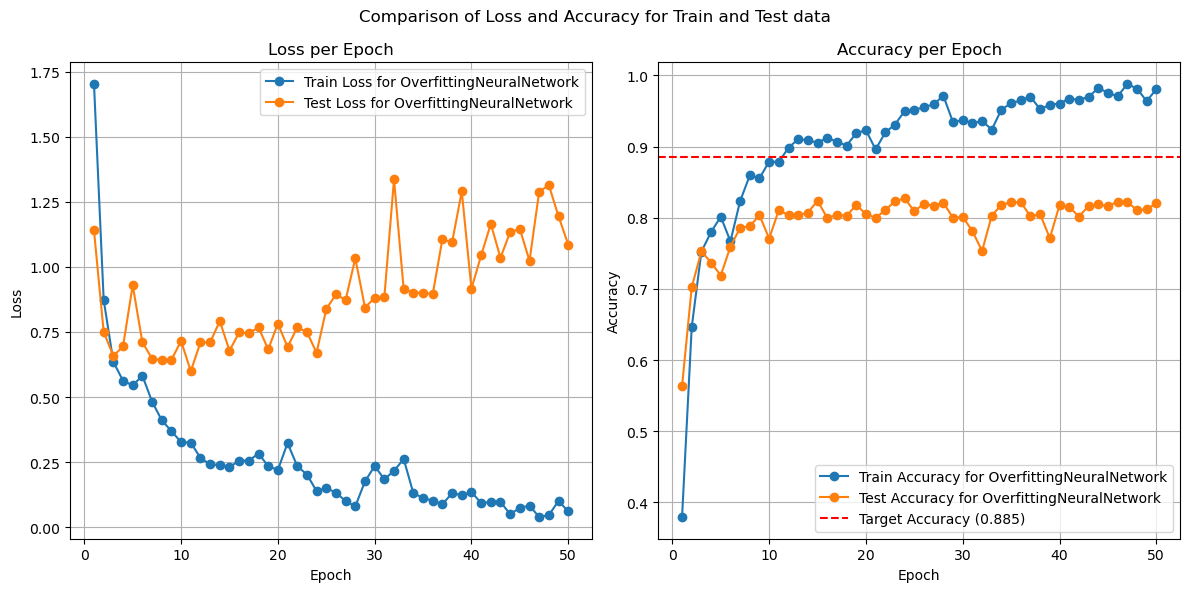

In [16]:

plot_func(train_loss_2, train_acc_2, test_loss_2, test_acc_2, 'Overfitting')

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [17]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.9),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [18]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
       BatchNorm1d-7                 [-1, 4096]           8,192
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 4096]      16,781,312
      BatchNorm1d-11                 [-1, 4096]           8,192
          Dropout-12                 [-1, 4096]               0
             ReLU-13                 [-1, 4096]               0
           Linear-14                 [-

In [ ]:
# Сделаем еще один небольшой набор данных на 100% больше чем маленький, для того, чтобы показать, что размер датасета тоже 
# является стабилизирующим обучение параметром

medium_train_set = torch.utils.data.Subset(fmnist_dataset_train, range(4000))
medium_train_loader = torch.utils.data.DataLoader(medium_train_set, batch_size=128, shuffle=True, num_workers=2)

In [20]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

lr = 1e-3

num_epochs = 50

train_loss_3, train_acc_3, test_loss_3, test_acc_3, model_3 = train_fasion(model, medium_train_loader, opt, loss_func, num_epochs=num_epochs)
# Your experiments, come here

Epoch: 0 	Train Loss: 1.536545 	Train Acc: 0.482 	Test Loss: 0.929982 	Test Accuracy: 0.715
Epoch: 1 	Train Loss: 0.945913 	Train Acc: 0.665 	Test Loss: 0.726416 	Test Accuracy: 0.736
Epoch: 2 	Train Loss: 0.773291 	Train Acc: 0.713 	Test Loss: 0.641514 	Test Accuracy: 0.756
Epoch: 3 	Train Loss: 0.696504 	Train Acc: 0.746 	Test Loss: 0.591211 	Test Accuracy: 0.781
Epoch: 4 	Train Loss: 0.659813 	Train Acc: 0.750 	Test Loss: 0.547213 	Test Accuracy: 0.797
Epoch: 5 	Train Loss: 0.628734 	Train Acc: 0.773 	Test Loss: 0.568292 	Test Accuracy: 0.790
Epoch: 6 	Train Loss: 0.585509 	Train Acc: 0.783 	Test Loss: 0.536376 	Test Accuracy: 0.811
Epoch: 7 	Train Loss: 0.572266 	Train Acc: 0.790 	Test Loss: 0.541067 	Test Accuracy: 0.803
Epoch: 8 	Train Loss: 0.537854 	Train Acc: 0.809 	Test Loss: 0.526505 	Test Accuracy: 0.812
Epoch: 9 	Train Loss: 0.534911 	Train Acc: 0.808 	Test Loss: 0.527459 	Test Accuracy: 0.817
Epoch: 10 	Train Loss: 0.561252 	Train Acc: 0.795 	Test Loss: 0.557809 	Test Acc

In [21]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.75),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.9),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.75),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 4096]       3,215,360
       BatchNorm1d-3                 [-1, 4096]           8,192
              ReLU-4                 [-1, 4096]               0
           Dropout-5                 [-1, 4096]               0
            Linear-6                 [-1, 4096]      16,781,312
       BatchNorm1d-7                 [-1, 4096]           8,192
              ReLU-8                 [-1, 4096]               0
           Dropout-9                 [-1, 4096]               0
           Linear-10                 [-1, 4096]      16,781,312
      BatchNorm1d-11                 [-1, 4096]           8,192
          Dropout-12                 [-1, 4096]               0
             ReLU-13                 [-1, 4096]               0
           Linear-14                 [-

In [22]:
num_epochs = 75
model1 = FixedNeuralNetwork().to(device)
opt = optim.SGD(model1.parameters(), momentum=0.3, lr=0.05)
loss_func = nn.CrossEntropyLoss()
train_loss_4, train_acc_4, test_loss_4, test_acc_4, model_4 = train_fasion(model1, medium_train_loader, opt, loss_func, num_epochs=num_epochs)

Epoch: 0 	Train Loss: 4.690159 	Train Acc: 0.148 	Test Loss: 2.093786 	Test Accuracy: 0.296
Epoch: 1 	Train Loss: 1.790900 	Train Acc: 0.458 	Test Loss: 1.502751 	Test Accuracy: 0.483
Epoch: 2 	Train Loss: 1.280679 	Train Acc: 0.560 	Test Loss: 1.007977 	Test Accuracy: 0.635
Epoch: 3 	Train Loss: 1.131895 	Train Acc: 0.618 	Test Loss: 1.044246 	Test Accuracy: 0.671
Epoch: 4 	Train Loss: 1.080170 	Train Acc: 0.641 	Test Loss: 0.873783 	Test Accuracy: 0.689
Epoch: 5 	Train Loss: 0.944263 	Train Acc: 0.683 	Test Loss: 0.839064 	Test Accuracy: 0.692
Epoch: 6 	Train Loss: 0.954321 	Train Acc: 0.690 	Test Loss: 1.119492 	Test Accuracy: 0.605
Epoch: 7 	Train Loss: 0.967983 	Train Acc: 0.689 	Test Loss: 0.846762 	Test Accuracy: 0.701
Epoch: 8 	Train Loss: 0.868698 	Train Acc: 0.711 	Test Loss: 0.773916 	Test Accuracy: 0.727
Epoch: 9 	Train Loss: 0.806922 	Train Acc: 0.722 	Test Loss: 0.859207 	Test Accuracy: 0.710
Epoch: 10 	Train Loss: 0.800252 	Train Acc: 0.725 	Test Loss: 0.903508 	Test Acc

Обучение на увеличенных в 2 раза данных с Adam


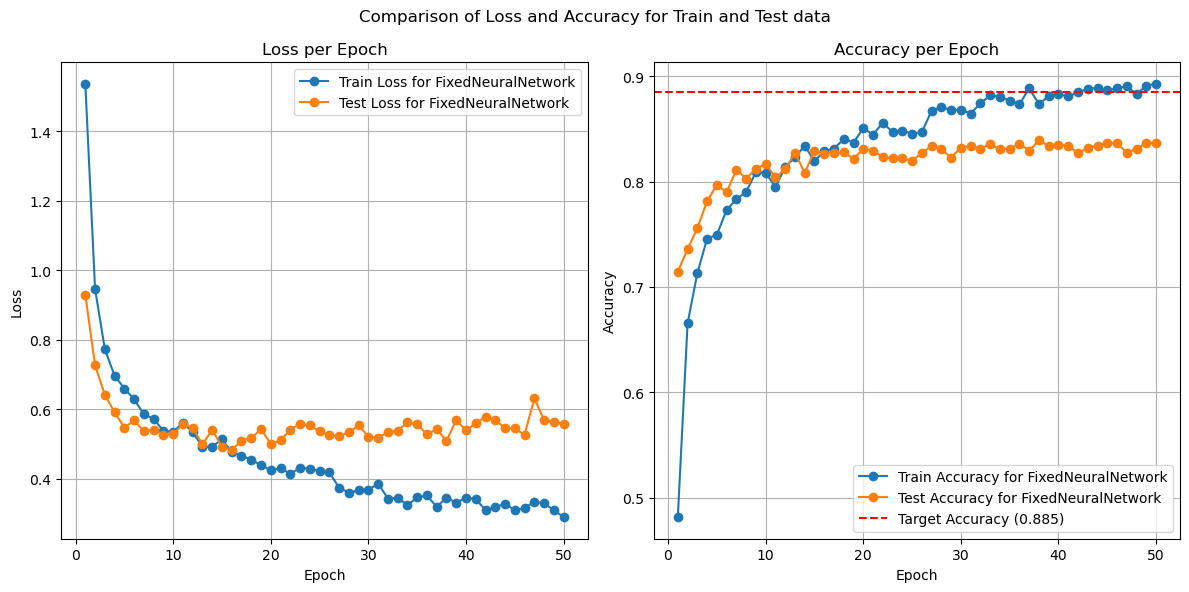

Обучение на увеличенных в 2 раза данных с SGD


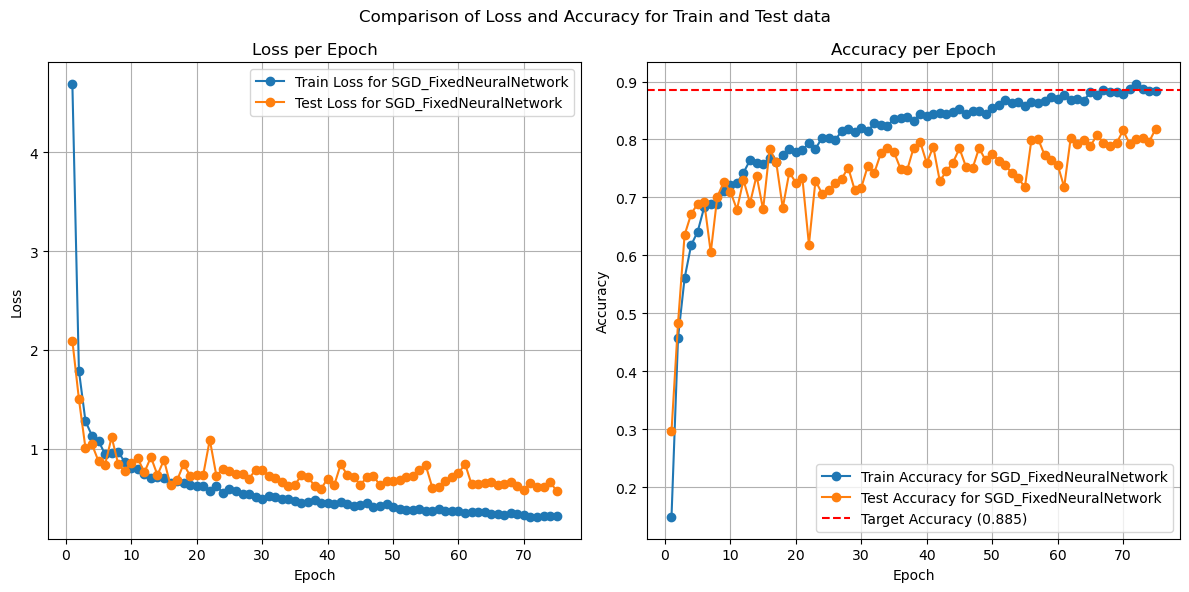

In [23]:
print("Обучение на увеличенных в 2 раза данных с Adam")
plot_func(train_loss_3, train_acc_3, test_loss_3, test_acc_3, 'Fixed')

print("Обучение на увеличенных в 2 раза данных с SGD")
plot_func(train_loss_4, train_acc_4, test_loss_4, test_acc_4, 'SGD_Fixed')


### Conclusions:
_Write down small report with your conclusions and your ideas._

**Для регуляризации были использованы:**
* Dropout - уменьшеает количество активных нейронов на каждой итерации обучения, следовательно меньше возможностей "запомнить" данные.
* BatchNormalization - вносится "шум" в бачи данных, что тоже способствует небольшой регуляризации модели.
* Увеличение объема данных, в данном случае на 100% (2000 до 4000), это как своего рода аугментация, которая как раз является одним из способов обучить модель на небольшом наборе данных и не получить переобучения.
* Получилось, что если поменять оптимизатор c Adam на SGD, то лосс на тестовой выборке колеблется в райне плато.

Таким образом получается, что такие методы неявной регуляризации повышают обобщающую способность модели и уменьшают переобучаение.